In [47]:
pip install opencv-python numpy matplotlip 

In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import glob
import math

In [49]:
def get_edges(img):
    """
    We tried to detect uing S channel (HLS), and V channel (HSV) with canny edge detection,
    but it detects the edges of left lane with some shades,
    then we tried to detect uing only V channel (HSV) with canny edge detection,
    but it can not detect lanes at the transition from shawoes to sun
    """
    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # h_channel = hls[:,:,0]
    # l_channel = hls[:,:,1]
    # s_channel = hls[:,:,2]
    # v_channel = hsv[:,:,2]
    # _,v_channel=cv2.threshold(v_channel,170, 255, cv2.THRESH_BINARY_INV)
    # edge1 = cv2.Canny(s_channel, 50, 150)
    # edge2 = cv2.Canny(v_channel, 50, 150)
    # edges = cv2.bitwise_or(edge1, edge2)
    # return edge2

    """
    We tried to detect lanes from gray scale image with sobel,
    but we replaced dark pixels with gray pixels to avoid detecting shadowes as edges.
    """
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    gray_image[gray_image <= 150] = 150
    
    # Sobel
    sobel = cv2.Sobel(gray_image, cv2.CV_64F,1,0)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint(255 * (abs_sobel / np.max(abs_sobel)))
    
    # Get binary edges
    th = (10, 150)
    l_binary = np.zeros_like(scaled_sobel)
    l_binary[(scaled_sobel > th[0]) & (scaled_sobel < th[1])] = 255
    
    return l_binary.astype('uint8')


def region_of_interest(img, width, height):
    vertices = [
        (0, height),
        (width / 2,height/2),
        (width, height)
    ]

    vertices = np.array([vertices], np.int32)

    mask = np.zeros_like(img)
    match_mask_color = 255 # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def addText(img, radious_of_curvature, deviation, dir):

    # Add the radius and center position to the image
    font = cv2.FONT_HERSHEY_TRIPLEX

    # Deviation
    curve = 'Radious of curvature: {:.1f} km.'.format(radious_of_curvature/1000)
    center = 'Away from the center by: {:.4f} m to the {}.'.format(deviation, dir)
    cv2.putText(img, curve, (70, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(img, center, (70, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return img

def show_image_single(image, title="title", cmap_type="gray"):
    f, (ax1) = plt.subplots(figsize=(20,10))
    ax1.imshow(image,cmap_type)
    ax1.set_title(title, fontsize=30)

def show_image(image1,image2, title1="title",title2="title", cmap_type="gray"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image1,cmap_type)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(image2,cmap_type)
    ax2.set_title(title2, fontsize=30)

def perspectiveTransform():
    src = np.float32([
        (550, 460),     # top-left
        (150, 720),     # bottom-left
        (1200, 720),    # bottom-right
        (770, 460)])    # top-right
    
    dst = np.float32([
        (100, 0),
        (100, 720),
        (1100, 720),
        (1100, 0)])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def warpPerspective(img, imgSize, M):
    return cv2.warpPerspective(img, M, imgSize, cv2.INTER_LINEAR)
def sliding_window(warped_image):
    global leftY, leftX

    leftx_base = 250
    rightx_base = 950

    # Convert binary image to RGB image to draw on it.
    out_img = cv2.cvtColor(warped_image, cv2.COLOR_GRAY2RGB)

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = int(height/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices (y)
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window+1)*window_height
        win_y_high = height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if (len(lefty) == 0):
        lefty = leftY
    else:
        leftY = lefty
    
    if (len(leftx) == 0):
        leftx = leftX
    else:
        leftX = leftx
        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit

def draw(window_img, left_fit, right_fit):
    ploty = np.linspace(height/3, height - 1, height)

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = cv2.cvtColor(warp_zero, cv2.COLOR_GRAY2RGB)
    
    # Get the value of left, and right lines equations
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    invWarp = warpPerspective(color_warp, (width, height), Minv)
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, invWarp, 0.3, 0)
    # result = cv2.bitwise_or(invWarp, image)

    return result, left_fitx, right_fitx

def get_measurments(img, leftx, rightx):
    # Generate y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    
    ym_per_pix = 30.5/720 # meters per pixel in y dimension 
    xm_per_pix = 3.7/720 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_curve = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_curve = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curve_value = ((1 + (2*left_curve[0]*y_eval*ym_per_pix + left_curve[1])**2)**1.5) / np.absolute(2*left_curve[0])
    right_curve_value = ((1 + (2*right_curve[0]*y_eval*ym_per_pix + right_curve[1])**2)**1.5) / np.absolute(2*right_curve[0])
    radious_of_curvature = np.average([left_curve_value, right_curve_value])
    
    #calculate car position
    car_pos = img.shape[1]/2
    
    #calculate lane center 
    left_point = left_curve[0]*img.shape[0]**2 + left_curve[1]*img.shape[0] + left_curve[2]
    rigth_point = right_curve[0]*img.shape[0]**2 + right_curve[1]*img.shape[0] + right_curve[2]
    lane_center_position = (left_point + rigth_point) /2
    deviation = (car_pos - lane_center_position) * xm_per_pix / 10
    
    if deviation < 0:
        dir = 'left'
    elif deviation > 0:
        dir = 'right'
    else:
        dir = 'center'

    return radious_of_curvature, np.absolute(deviation), dir

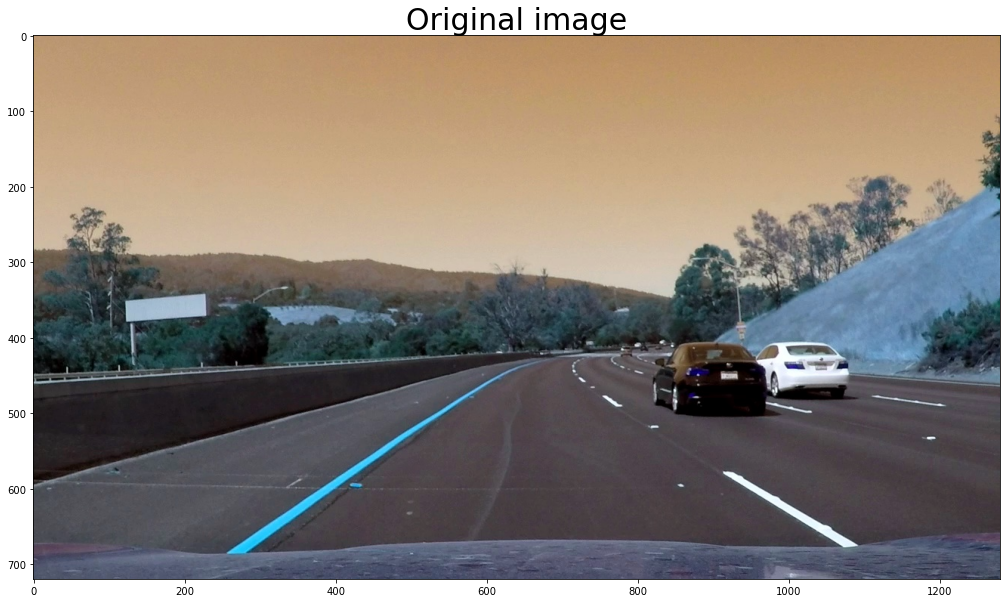

In [50]:
image = cv2.imread("test_image/0.jpg")
show_image_single(image, "Original image")

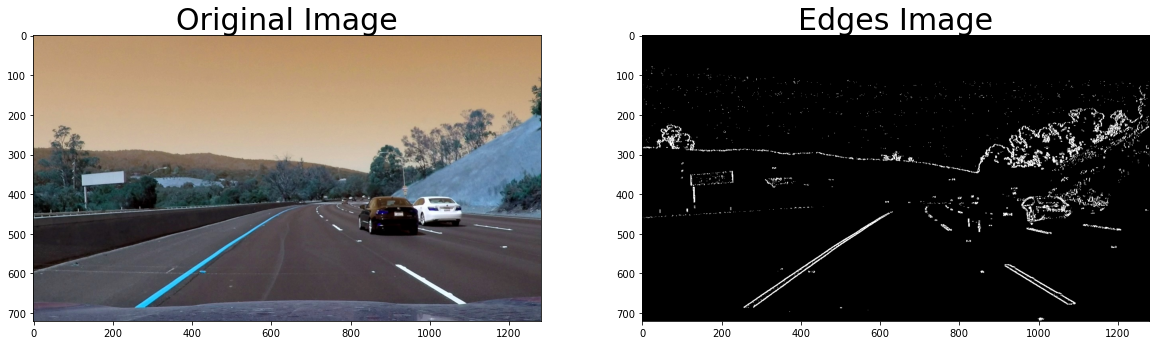

In [51]:
height = image.shape[0]
width = image.shape[1]
edges = get_edges(image)
show_image(image,edges,"Original Image","Edges Image")

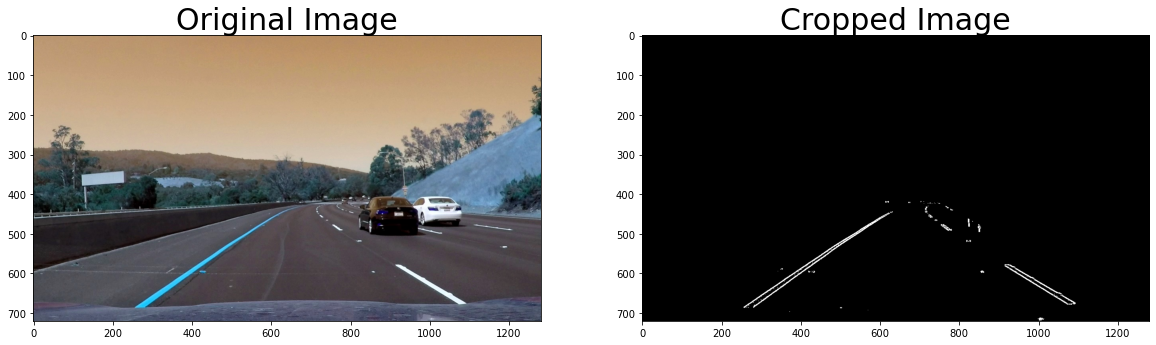

In [52]:
cropped_image = region_of_interest(edges, width, height)
show_image(image,cropped_image,"Original Image","Cropped Image")

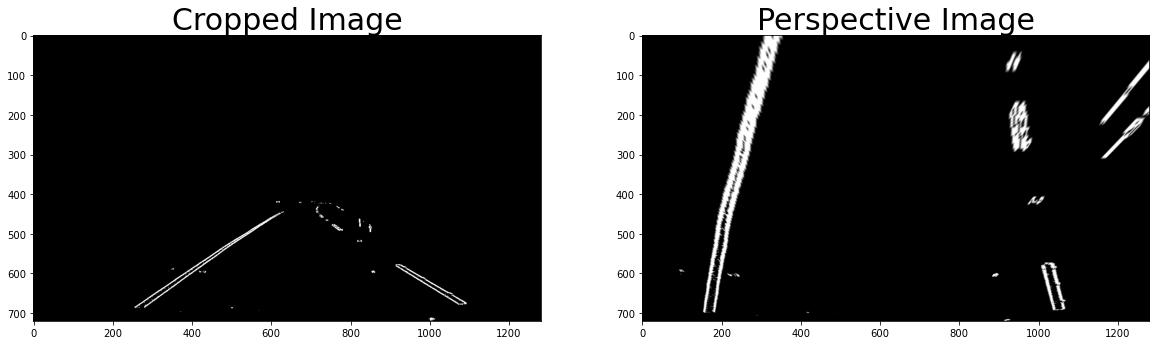

In [53]:
M, Minv = perspectiveTransform()
size = cropped_image.shape[1::-1]
warped_image = warpPerspective(cropped_image.astype(np.float32), size, M)
show_image(cropped_image,warped_image,"Cropped Image","Perspective Image")

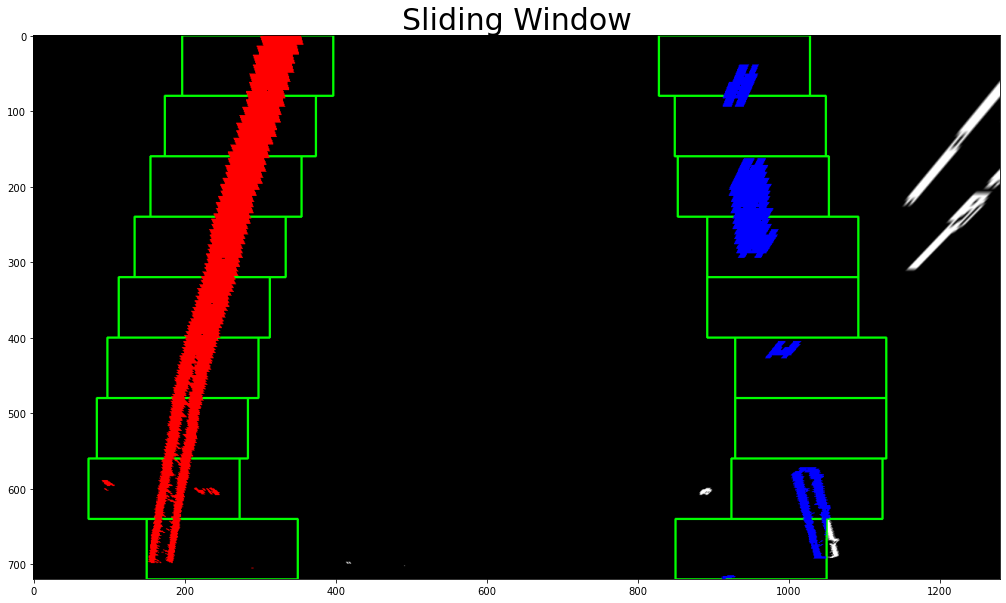

In [54]:
window_img, left_fit, right_fit = sliding_window(warped_image)
show_image_single(window_img.astype('uint8'), "Sliding Window")

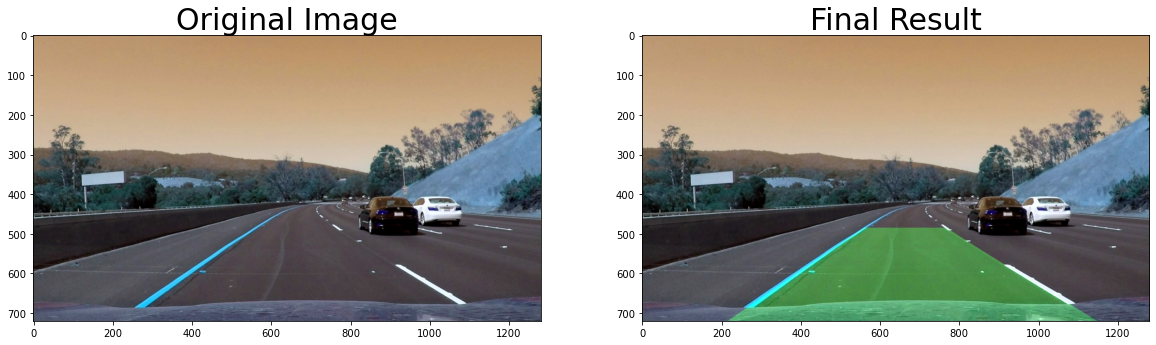

In [55]:
result, left_fitx, right_fitx = draw(window_img, left_fit, right_fit)
show_image(image,result,"Original Image","Final Result","gray")

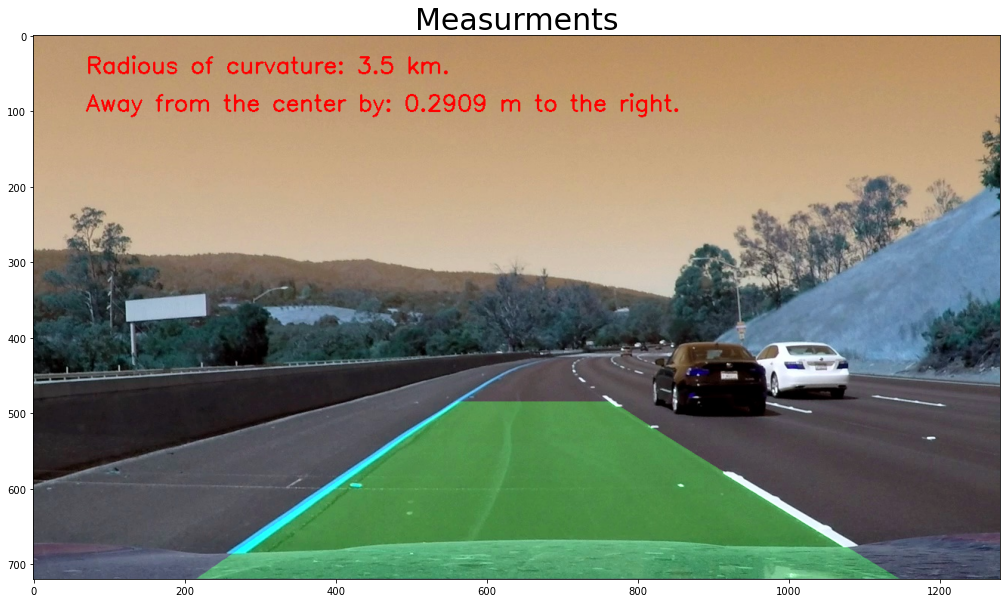

In [56]:
radious_of_curvature, deviation, dir = get_measurments(image, left_fitx, right_fitx)        
result = addText(result , radious_of_curvature, deviation, dir)
show_image_single(result,"Measurments","gray")